In [1]:
import pandas as pd
import numpy as np
import pickle as pkl

import sys
sys.path.append('../')
from utils import *

In [2]:
df = pd.read_pickle('../../data/datasets/raw-video-level-watches')
videos = pd.read_pickle('../../data/videos_raw_metadata')
title_embeddings = pd.read_pickle('../../data/embeddings/title-autoencoded')

In [3]:
X = []
Y = []
for watch in tqdm(df):
    playing = watch['playing']
    selected = watch['selected']
    if playing not in videos or selected not in videos or any([s not in videos for s in watch['upnext']]):
        continue

    if len(watch['upnext']) < 15:
        continue
        
    upnext = watch['upnext'][:15]
    for s in upnext:
        playing = watch['playing']
        selected = watch['selected']

        if s == selected:
            y = 1
        else:
            y = 0

        playing = np.array(title_embeddings[videos[playing]['snippet']['title']])[0]
        suggested = np.array(title_embeddings[videos[s]['snippet']['title']])[0]
        all_suggested = [np.array(title_embeddings[videos[s]['snippet']['title']])[0] for s in upnext]

        all_suggested = np.array(all_suggested).flatten()
        
        x = np.concatenate([playing, suggested, all_suggested])

        X.append(x)
        Y.append(y)

In [4]:
X = np.array(X)
Y = np.array(Y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1, stratify=Y)

In [6]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
X_train.shape

(55188, 2176)

In [17]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

{0: 0.534742570113018, 1: 7.69578313253012}

In [ ]:
# train neural network

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD


model = Sequential()
model.add(Dense(1600, activation='relu', input_dim=2176))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(800, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(400, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9)

METRICS = [keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'), 
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc'),       
            keras.metrics.AUC(name='prc', curve='PR')]
# import sgd

model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=METRICS)

model.fit(X_train, y_train,
            epochs=100,
            batch_size=64, 
            class_weight=class_weights)

/home/hussam/.local/lib/python3.6/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
863/863 [==============================] - 73s 81ms/step - loss: 0.6937 - tp: 1459.0000 - fp: 21576.0000 - tn: 30026.0000 - fn: 2127.0000 - accuracy: 0.5705 - precision: 0.0633 - recall: 0.4069 - auc: 0.4914 - prc: 0.0633
Epoch 2/100
863/863 [==============================] - 71s 82ms/step - loss: 0.6933 - tp: 2490.0000 - fp: 35944.0000 - tn: 15658.0000 - fn: 1096.0000 - accuracy: 0.3288 - precision: 0.0648 - recall: 0.6944 - auc: 0.4915 - prc: 0.0629
Epoch 3/100
863/863 [==============================] - 71s 82ms/step - loss: 0.6933 - tp: 2901.0000 - fp: 42405.0000 - tn: 9197.0000 - fn: 685.0000 - accuracy: 0.2192 - precision: 0.0640 - recall: 0.8090 - auc: 0.4916 - prc: 0.0633
Epoch 4/100
863/863 [==============================] - 71s 82ms/step - loss: 0.6932 - tp: 846.0000 - fp: 12416.0000 - tn: 39186.0000 - fn: 2740.0000 - accuracy: 0.7254 - precision: 0.0638 - recall: 0.2359 - auc: 0.4968 - prc: 0.0645
Epoch 5/100
863/863 [==============================] - 71s 82ms/ste

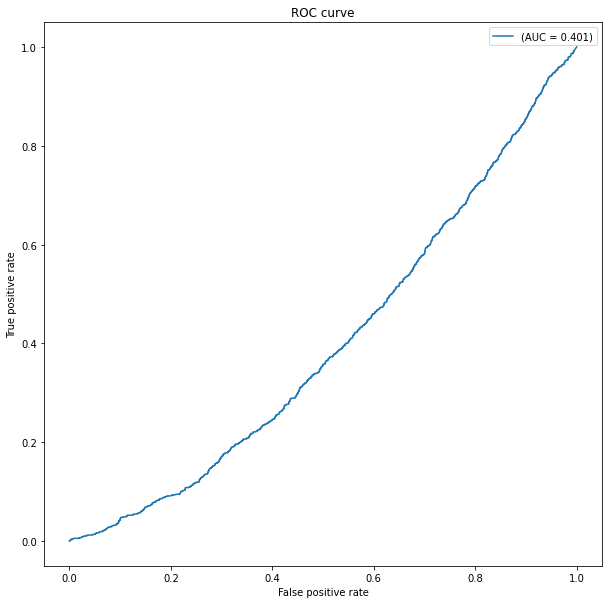

In [19]:
# plot auc curve for test

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()